# ASHRAE - Great Energy Predictor III

### Importing the libraries

In [0]:
# !pip install tensorflow==2.0.0
# !pip install kaggle

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import numpy as np
import pandas as pd

import os
import gc
import math
from datetime import datetime

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 64
plt.rcParams['figure.figsize'] = [12, 8]
%matplotlib inline

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import lightgbm as lgb

In [0]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Embedding, concatenate, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.losses import mean_squared_error as mse_loss
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

### Downloading the Kaggle competition dataset

In [0]:
os.environ['KAGGLE_USERNAME'] = "faresgaaloul"
os.environ['KAGGLE_KEY'] = "0f87a31edc1b58ed0830ba14c093815b"

In [5]:
!kaggle competitions download -c ashrae-energy-prediction

  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 16.8MB/s]
 97% 86.0M/88.4M [00:03<00:00, 29.7MB/s]
100% 88.4M/88.4M [00:03<00:00, 27.5MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 83.2MB/s]
 95% 159M/167M [00:02<00:00, 50.4MB/s]
100% 167M/167M [00:02<00:00, 64.3MB/s]
 94% 113M/120M [00:04<00:00, 35.2MB/s]
100% 120M/120M [00:04<00:00, 29.0MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 183MB/s]


In [6]:
!unzip '/content/*.csv.zip'
!rm -v /content/*.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               

Archive:  /content/test.csv.zip
  inflating: test.csv                

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  /content/weather_train.csv.zip
  inflating: weather_train.csv       

Archive:  /content/weather_test.csv.zip
  inflating: weather_test.csv        

5 archives were successfully processed.
removed '/content/sample_submission.csv.zip'
removed '/content/test.csv.zip'
removed '/content/train.csv.zip'
removed '/content/weather_test.csv.zip'
removed '/content/weather_train.csv.zip'


### Importing the dataset


In [7]:
%%time
root = './'
train = pd.read_csv(root + 'train.csv')
test = pd.read_csv(root + 'test.csv')
weather_train = pd.read_csv(root + 'weather_train.csv')
weather_test = pd.read_csv(root + 'weather_test.csv')
building = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

CPU times: user 25.3 s, sys: 3.35 s, total: 28.7 s
Wall time: 28.7 s


In [8]:
print('Size of train data', train.shape)
print('Size of test data', test.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)
print('Size of building data', building.shape)

Size of train data (20216100, 4)
Size of test data (41697600, 4)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)
Size of building data (1449, 6)


### Exploratory data analysis

#### Helper plotting functions

In [0]:
def plot_dist(df, column, func=lambda x: x):
    plt.figure(figsize=(12,8))
    ax = sns.distplot(df[column].dropna().map(func))
    ax.set_title(column+" Distribution", fontsize=16)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("distribution", fontsize=12)
    plt.show()

**meter_reading** - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.


In [10]:
train['meter_reading'].describe()

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

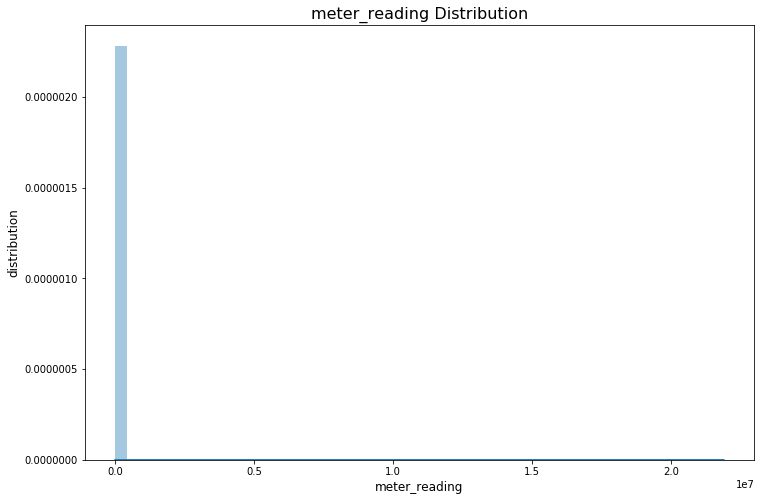

In [11]:
plot_dist(train, 'meter_reading')

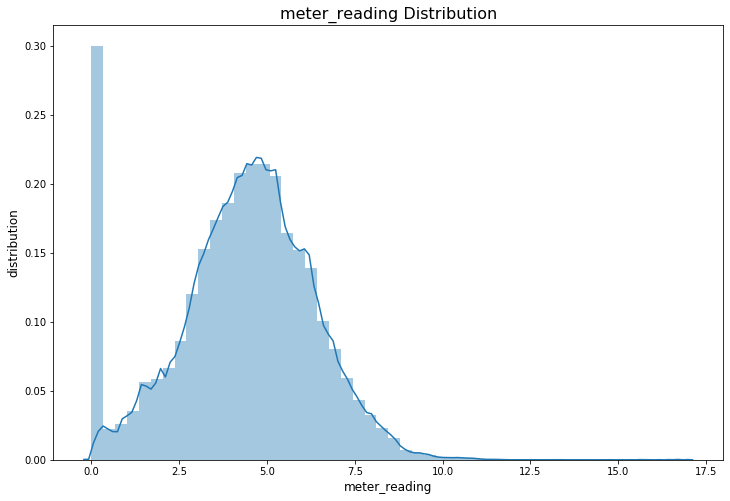

In [12]:
### Data is heavily skewed, we'll apply np.log1p to see how it affects the distribution
plot_dist(train, 'meter_reading', np.log1p)

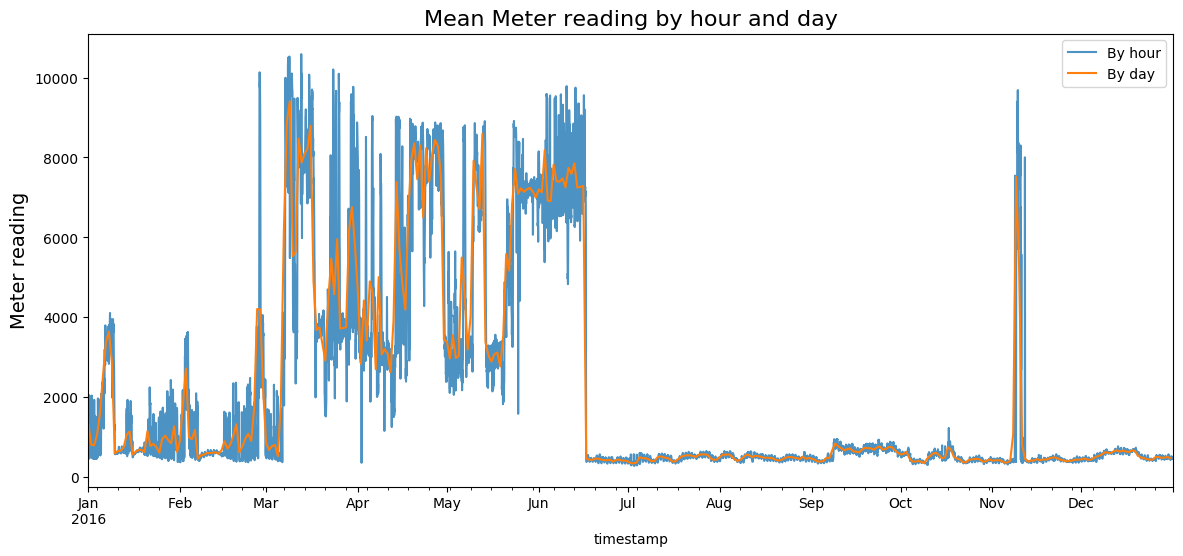

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

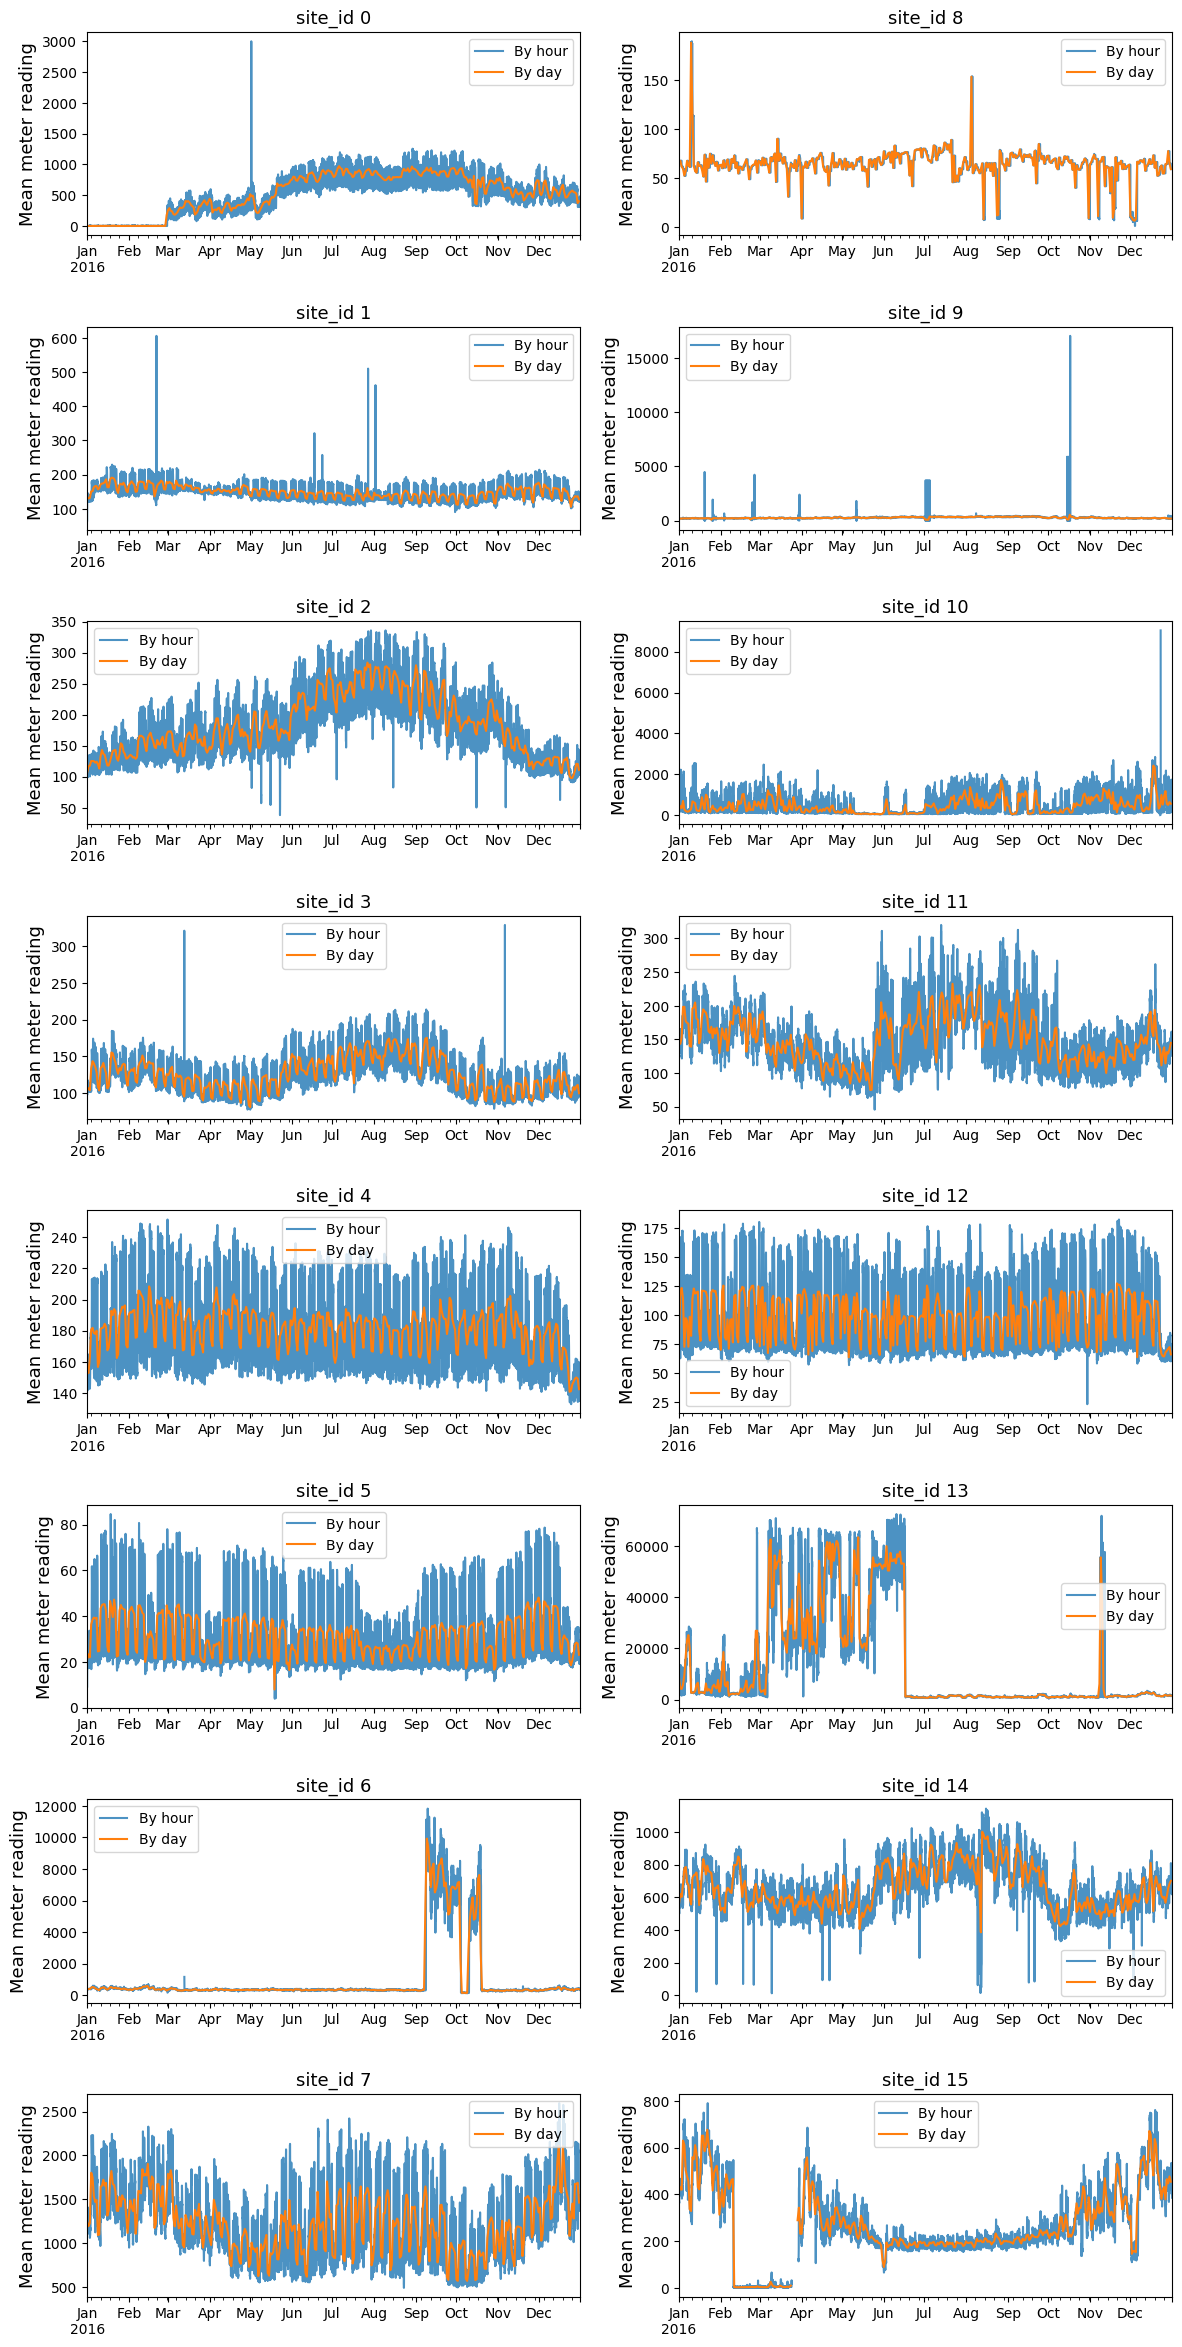

In [87]:
temp_df = train.copy()
temp_df = temp_df.merge(building, on='building_id', how='left')
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(temp_df['site_id'].nunique()):
    temp_df[temp_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    temp_df[temp_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

**meter** - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.


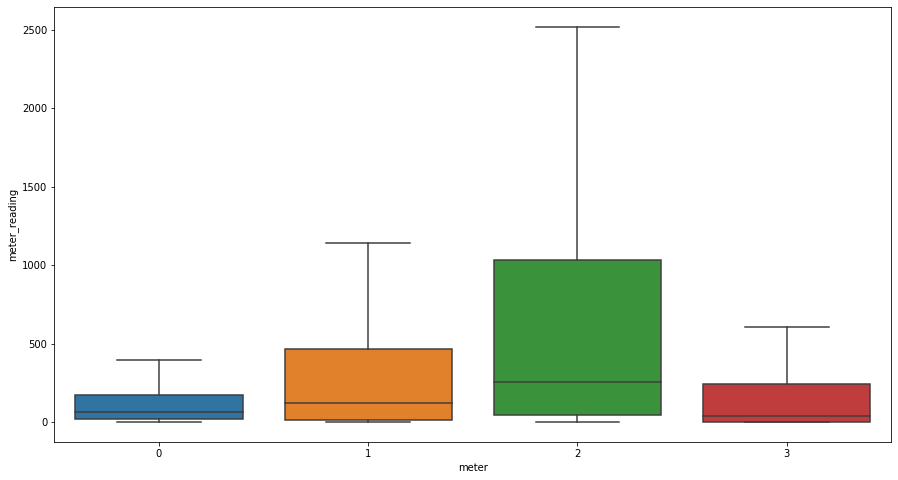

In [13]:
plt.figure(figsize=(15,8))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False)

**primary_use** - Indicator of the primary category of activities for the building based on EnergyStar property type definitions


9763

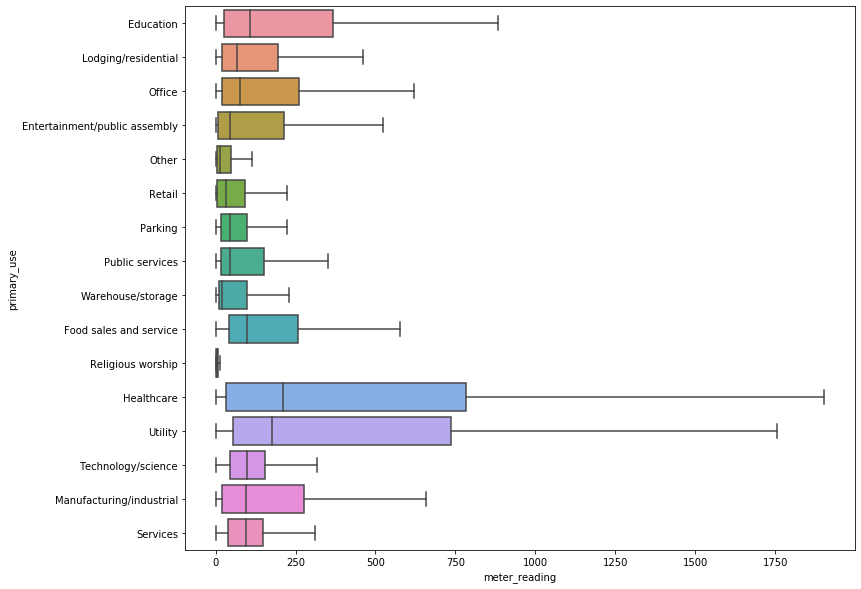

In [25]:
temp_df = train.copy()
temp_df = train.merge(building, on='building_id', how='left')
plt.figure(figsize=(12,10))
sns.boxplot(x='meter_reading', y='primary_use', data=temp_df, showfliers=False)
del temp_df; gc.collect()

**square_feet** - Gross floor area of the building


In [26]:
building['square_feet'].describe()

count      1449.000000
mean      92111.776398
std      110769.950997
min         283.000000
25%       23012.000000
50%       57673.000000
75%      115676.000000
max      875000.000000
Name: square_feet, dtype: float64

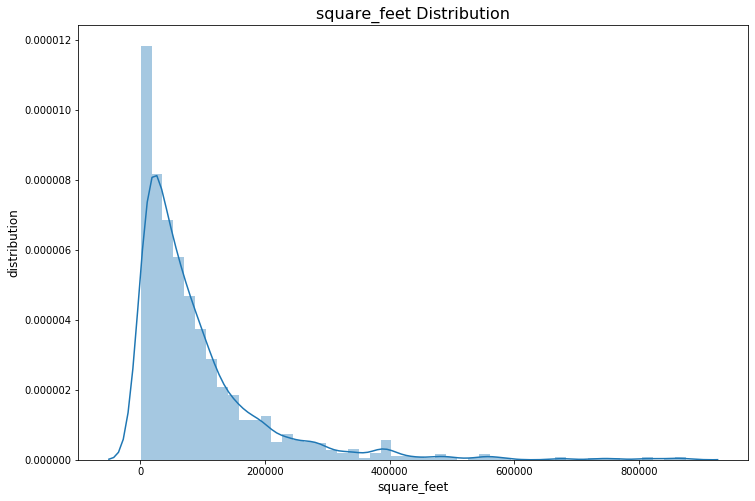

In [28]:
plot_dist(building, 'square_feet')

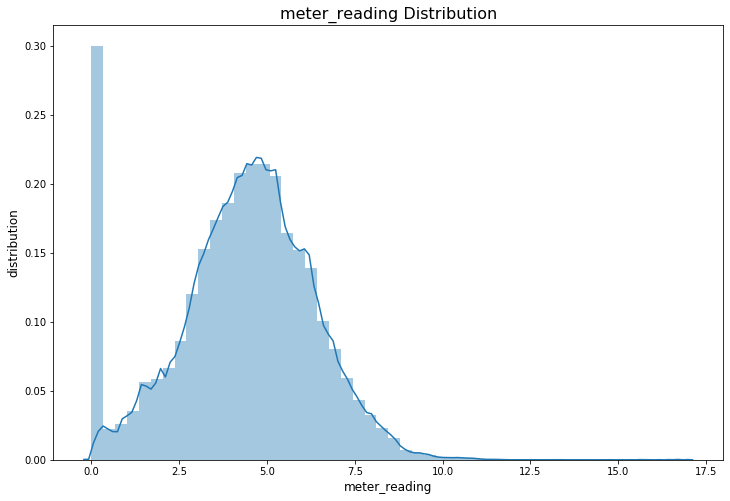

In [29]:
### Data is heavily skewed, we'll apply np.log1p to see how it affects the distribution
plot_dist(train, 'meter_reading', np.log1p)

**year_built** - Year building was opened


In [40]:
building.isna().sum().sort_values(ascending=False)*100 / len(building)

floor_count    75.500345
year_built     53.416149
square_feet     0.000000
primary_use     0.000000
building_id     0.000000
site_id         0.000000
dtype: float64

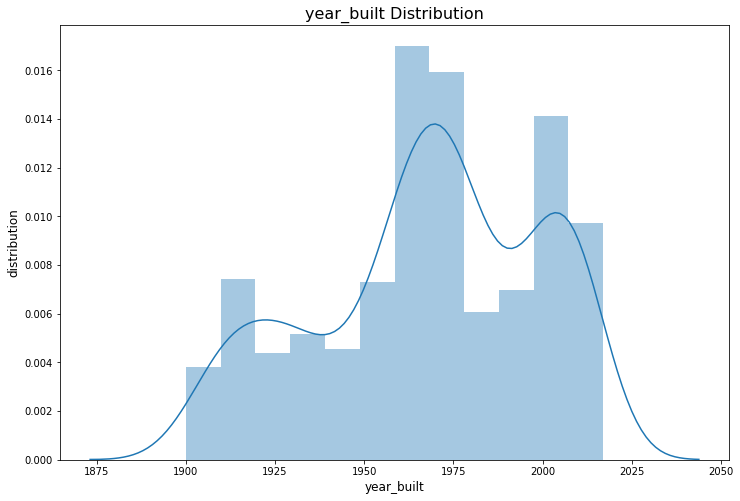

In [30]:
plot_dist(building, 'year_built')

**floor_count** - Number of floors of the building


In [34]:
building['floor_count'].value_counts()

1.0     109
2.0      67
4.0      37
3.0      33
5.0      25
6.0      25
8.0      19
7.0      14
9.0       8
11.0      5
10.0      4
12.0      2
13.0      2
19.0      1
26.0      1
14.0      1
21.0      1
16.0      1
Name: floor_count, dtype: int64

1070858

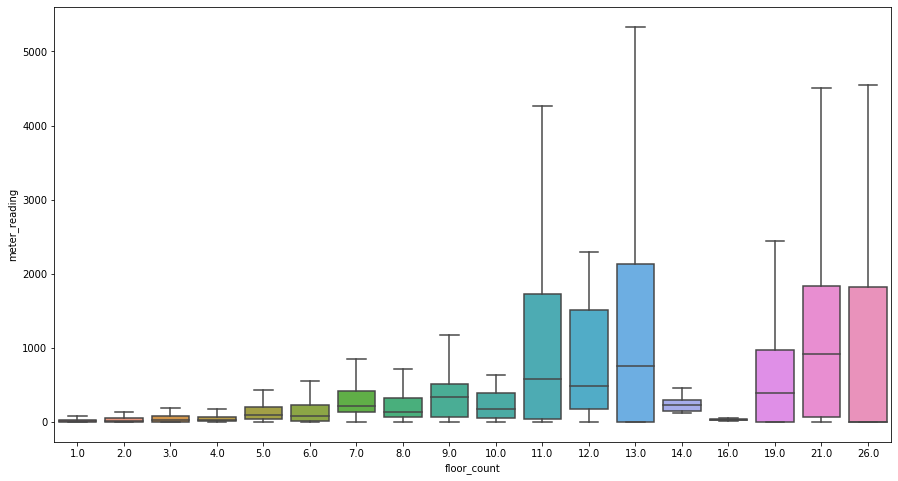

In [59]:
temp_df = train.copy()
temp_df = train.merge(building, on='building_id', how='left')
plt.figure(figsize=(15,8))
sns.boxplot(x='floor_count', y='meter_reading', data=temp_df, showfliers=False)
del temp_df; gc.collect()

**air_temperature** - Degrees Celsius


In [41]:
weather_train.isna().sum().sort_values(ascending = False) * 100 / len(weather_train)

cloud_coverage        49.489529
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
dew_temperature        0.080845
air_temperature        0.039350
timestamp              0.000000
site_id                0.000000
dtype: float64

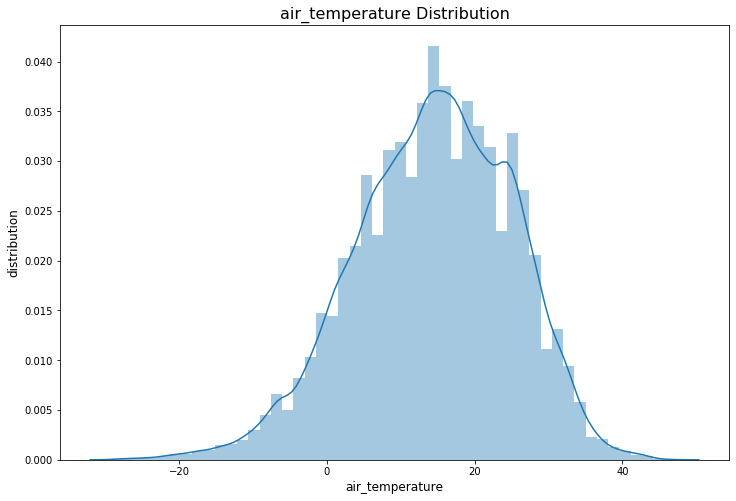

In [39]:
plot_dist(weather_train, 'air_temperature')

**dew_temperature** - Degrees Celsius


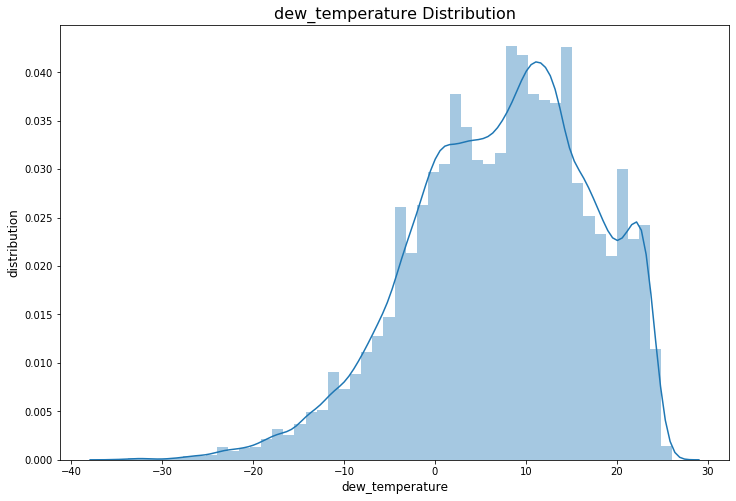

In [42]:
plot_dist(weather_train, 'dew_temperature')

**wind_speed** - Meters per second


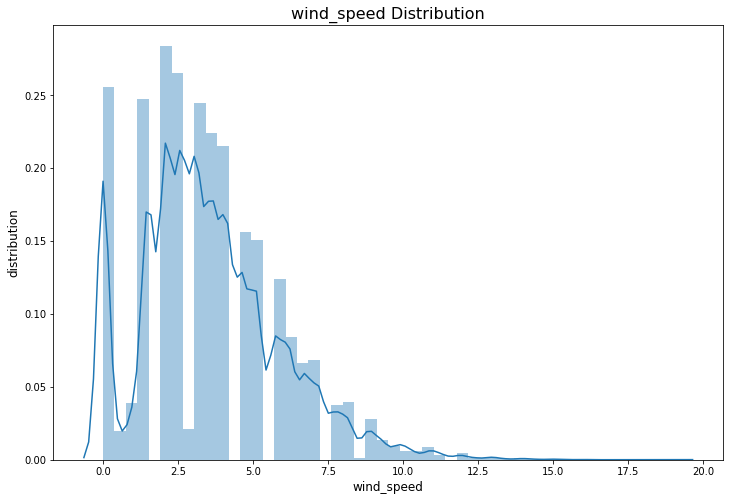

In [43]:
plot_dist(weather_train, 'wind_speed')

**wind_direction** - Compass direction (0-360)

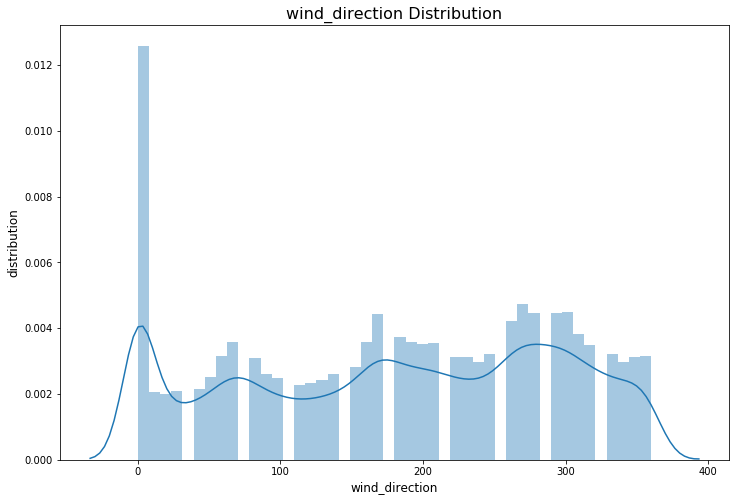

In [45]:
plot_dist(weather_train, 'wind_direction')

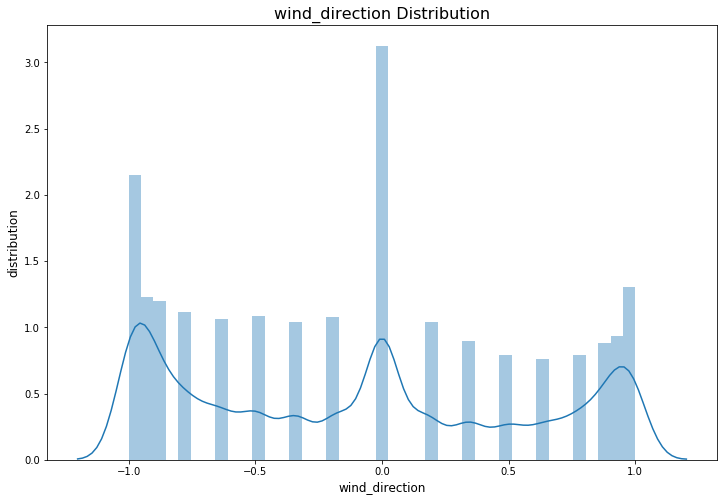

In [51]:
sinus = lambda x: np.sin((2*np.pi*x)/360)
plot_dist(weather_train, 'wind_direction', sinus)

**cloud_coverage** - Portion of the sky covered in clouds, in oktas


10840

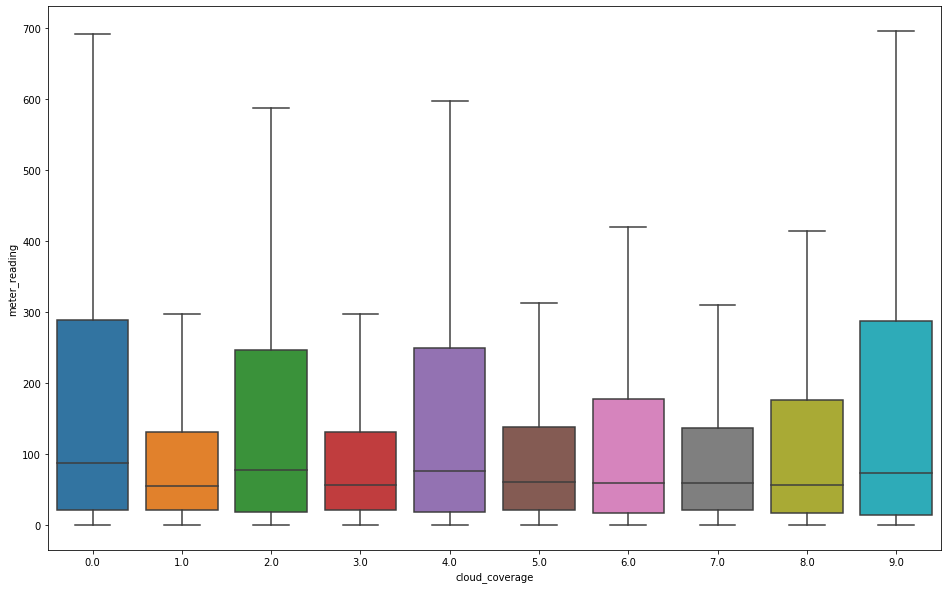

In [63]:
temp_df = train.copy()
temp_df = train.merge(building, on='building_id', how='left')
temp_df = temp_df.merge(weather_train, on=['site_id', 'timestamp'], how='left')
plt.figure(figsize=(16,10))
sns.boxplot(x='cloud_coverage', y='meter_reading', data=temp_df, showfliers=False)
del temp_df; gc.collect()

**sea_level_pressure** - Millibar/hectopascals


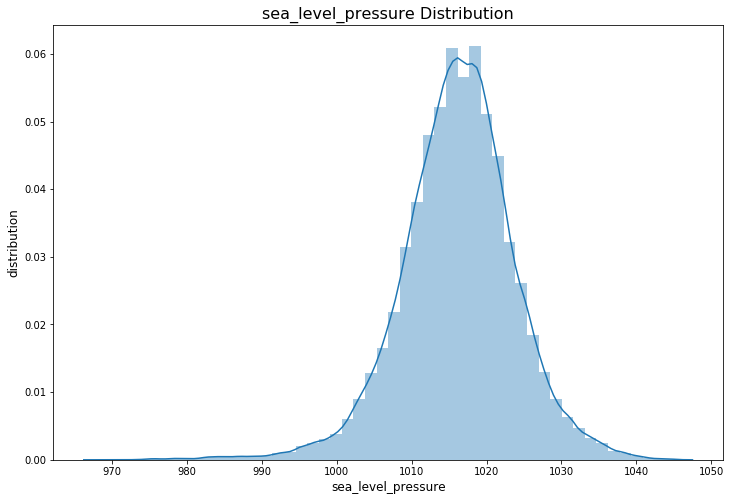

In [64]:
plot_dist(weather_train, 'sea_level_pressure')

**precip_depth_1_hr** - Millimeters


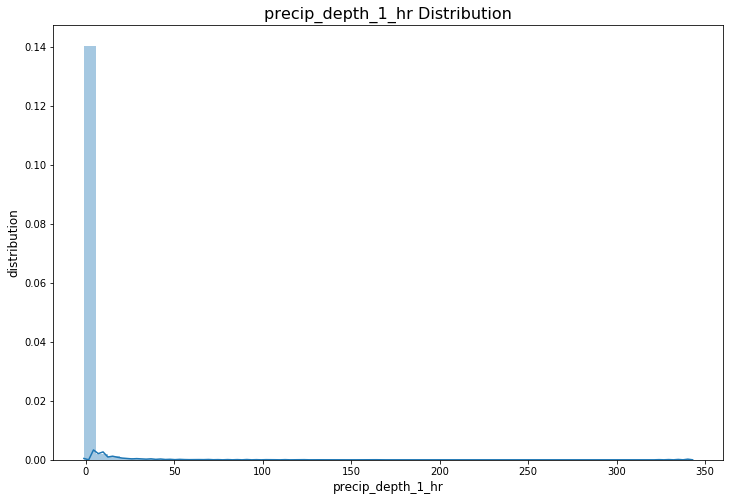

In [65]:
plot_dist(weather_train, 'precip_depth_1_hr')

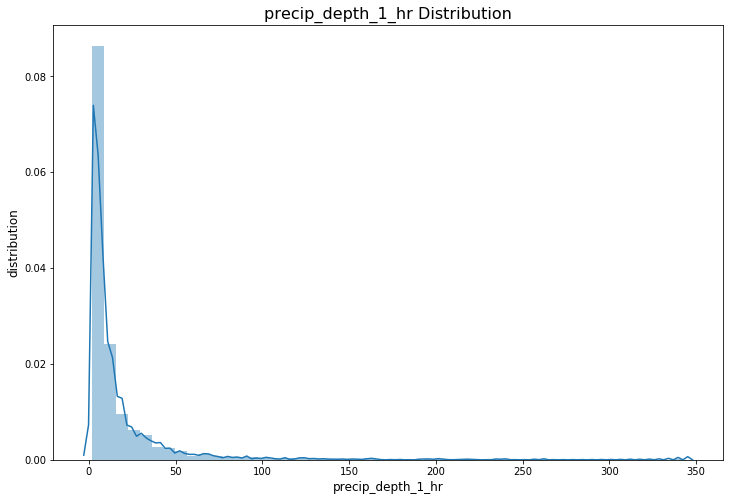

In [69]:
plot_dist(weather_train[weather_train['precip_depth_1_hr'] > 0], 'precip_depth_1_hr')

### Data processing pipeline
  - Fixing timestamp
  - Replacing missing values
  - Label encoding
  <!-- - Scaling continuous features -->
  - Feature engineering
  - Merging datasets
  - Reducing memory usage

#### Data processing for building dataset

In [0]:
def process_building_data(building_df):
  # print('Data Cleaning: Deleting floor_count column')
  # building_df.drop(columns=['floor_count'], inplace=True)
  print('Data cleaning: Replacing null values for floor_count column')
  building_df.floor_count.fillna(round(building_df.floor_count.mean(),0), inplace=True)
  
  print('Feature engineering: Creating building_age column')
  current_year = datetime.now().year
  building_df['building_age'] = current_year - building_df['year_built']
    
  print('Data Cleaning: Deleting floor_count column')
  building_df.drop(columns=['year_built'], inplace=True)

  print('Data cleaning: Replacing null values in building_age column')
  building_df.building_age.fillna(round(building_df.building_age.mean(),0), inplace=True)

  print('Feature engineering: Label encoding primary use')
  le = LabelEncoder()
  le_primary_use = le.fit_transform(building.primary_use)

  print('Feature engineering: Log normalization for square_feet column')
  building_df['log_square_feet'] = np.log(building_df['square_feet'])
  building_df.drop(columns=['square_feet'], inplace=True)

  building_df['primary_use'] = le_primary_use

  del current_year, le, le_primary_use
  gc.collect()

  return building_df

#### Data processing for weather dataset

In [0]:
def convert_season(month):
    if (month <= 2) | (month == 12):
        return 0
    # as winter
    elif month <= 5:
        return 1
    # as spring
    elif month <= 8:
        return 2
    # as summer
    elif month <= 11:
        return 3
    # as fall

def convert_direction(degrees):
    if degrees <= 90:
        return 0
    # as norteast direction
    elif degrees <= 180:
        return 1
    # as southeast direction
    elif degrees <= 270:
        return 2
    # as southwest direction
    elif degrees <= 360:
        return 3
    # as northwest direction

In [0]:
def add_beaufort_scale(df):
  beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

  for item in beaufort:
    df.loc[(df['wind_speed'] >= item[1]) & (df['wind_speed'] < item[2]), 'beaufort_scale'] = item[0]
  return df

In [0]:
def replace_weather_data_nans(weather_df):
  weather_df = weather_df.set_index(['site_id','day_of_month','month'])
                        
  weather_features_with_nan = {
      'air_temperature': {'round': 1, 'fill': False},
      'dew_temperature': {'round': 1, 'fill': False},
      'wind_speed': {'round': 1, 'fill': False},
      'wind_direction': {'round': 0, 'fill': False},
      'sea_level_pressure': {'round': 1, 'fill': True},
      'precip_depth_1_hr': {'round': 0, 'fill': True},
      'cloud_coverage': {'round': 0, 'fill': True}
  }

  for feature, params in weather_features_with_nan.items():
    print('Data cleaning: Replacing NAN values for ' + feature)
    filler_df = pd.DataFrame(weather_df.groupby(['site_id','day_of_month','month'])[feature].mean().round(params['round']),
                             columns=[feature])

    if params['fill']:
      filler_df_mean = round(filler_df[feature].mean(),params['round'])
      filler_df.fillna(filler_df_mean, inplace=True)
    # create dataframe of air_temperatures to fill
    temporary_df = pd.DataFrame({feature : weather_df[feature]})

    # update NA air_temperature values
    temporary_df.update(filler_df, overwrite=False)

    # update in the weather dataset
    weather_df[feature] = temporary_df[feature]
  weather_df = weather_df.reset_index()
  return weather_df

In [0]:
def process_weather_data(weather_df):
  print('Data cleaning: Converting timestamp column')
  weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"])

  print('Feature engineering: Adding month, day of week, day of month and hour columns')
  weather_df['month'] = weather_df['timestamp'].dt.month
  weather_df['day_of_week'] = weather_df['timestamp'].dt.dayofweek
  weather_df['day_of_month']= weather_df['timestamp'].dt.day
  weather_df['hour'] = weather_df['timestamp'].dt.hour

  print('Feature engineering: Adding is_weekend feature')
  weather_df['is_weekend'] = weather_df.day_of_week.apply(lambda x: 1 if x>=5 else 0)

  print('Feature engineering: Adding season feature')
  weather_df['season'] = weather_df.month.apply(convert_season)

  print('Data cleaning: Replacing NAN values')
  weather_df = replace_weather_data_nans(weather_df)

  print('Feature engineering: Adding beaufort_scale feature')
  weather_df = add_beaufort_scale(weather_df)

  print('Feature engineering: adding wind_compass_direction feature')
  weather_df['wind_direction'+'_compass'] = weather_df.wind_direction.apply(convert_direction)

  print('Feature engineering: adding wind_direction_sin features')
  weather_df['wind_direction'+'_sin'] = np.sin((2*np.pi*weather_df['wind_direction'])/360)

  print('Data cleaning: Dropping wind_direction feature')
  weather_df.drop(columns=['wind_direction'], inplace=True)

  return weather_df

#### Train dataset processing

*   Merging datasets
*   Reducing memory usage





In [0]:
def reduce_memory_usage(df):
  d_types = {'building_id': np.uint16,
            'site_id': np.uint8,
            'meter': np.uint8,
            'primary_use': np.uint8,
            'log_square_feet': np.float16,
            'floor_count': np.uint8,
            'building_age': np.uint8,
            'air_temperature': np.float16,
            'dew_temperature': np.float16,
            'wind_speed': np.float16,
            'cloud_coverage': np.uint8,
            'precip_depth_1_hr': np.int16,
            'sea_level_pressure': np.float32,
            'wind_direction_sin': np.float16,
            'wind_direction_compass': np.uint8,
            'beaufort_scale': np.uint8,
            'day_of_month': np.uint8,
            'month': np.uint8,
            'day_of_week': np.uint8,
            'hour': np.uint8,
            'is_weekend': np.uint8,
            'season': np.uint8
            }

  for feature in d_types:
    df[feature] = df[feature].astype(d_types[feature])
  return df


In [0]:
def data_processing_pipeline(df, weather_df, building_df, target_variable='meter_reading'):

  print('Data cleaning: Fixing timestamp')
  df["timestamp"] = pd.to_datetime(df["timestamp"])
  
  print('\nProcessing building data:\n')
  building_df_copy = building_df.copy()
  building_df_copy = process_building_data(building_df_copy)

  print('\nProcessing weather data:\n')
  weather_df_copy = weather_df.copy()
  weather_df_copy = process_weather_data(weather_df_copy)

  print('\nMerging datasets:\n')
  print('Merging with building dataset')
  df = df.merge(building_df_copy, on='building_id', how='left')
  print('Merging with weather dataset')
  df = df.merge(weather_df_copy, on=['site_id', 'timestamp'], how='left')

  print('\nData cleaning: Imputing missing data after merging datasets')
  columns_with_nan = df.columns[df.isna().any()]
  for feature in columns_with_nan:
    df[feature] = df[feature].fillna(method='ffill')

  print('\nReducing memory usage:\n')
  start_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
  df = reduce_memory_usage(df)
  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%\n'.format(100 * (start_mem - end_mem) / start_mem))

  del weather_df_copy, building_df_copy, start_mem, end_mem
  gc.collect()
  return df

In [81]:
%%time
train_copy = data_processing_pipeline(train, weather_train, building)

Data cleaning: Fixing timestamp

Processing building data:

Data cleaning: Replacing null values for floor_count column
Feature engineering: Creating building_age column
Data Cleaning: Deleting floor_count column
Data cleaning: Replacing null values in building_age column
Feature engineering: Label encoding primary use
Feature engineering: Log normalization for square_feet column

Processing weather data:

Data cleaning: Converting timestamp column
Feature engineering: Adding month, day of week, day of month and hour columns
Feature engineering: Adding is_weekend feature
Feature engineering: Adding season feature
Data cleaning: Replacing NAN values
Data cleaning: Replacing NAN values for air_temperature
Data cleaning: Replacing NAN values for dew_temperature
Data cleaning: Replacing NAN values for wind_speed
Data cleaning: Replacing NAN values for wind_direction
Data cleaning: Replacing NAN values for sea_level_pressure
Data cleaning: Replacing NAN values for precip_depth_1_hr
Data cle

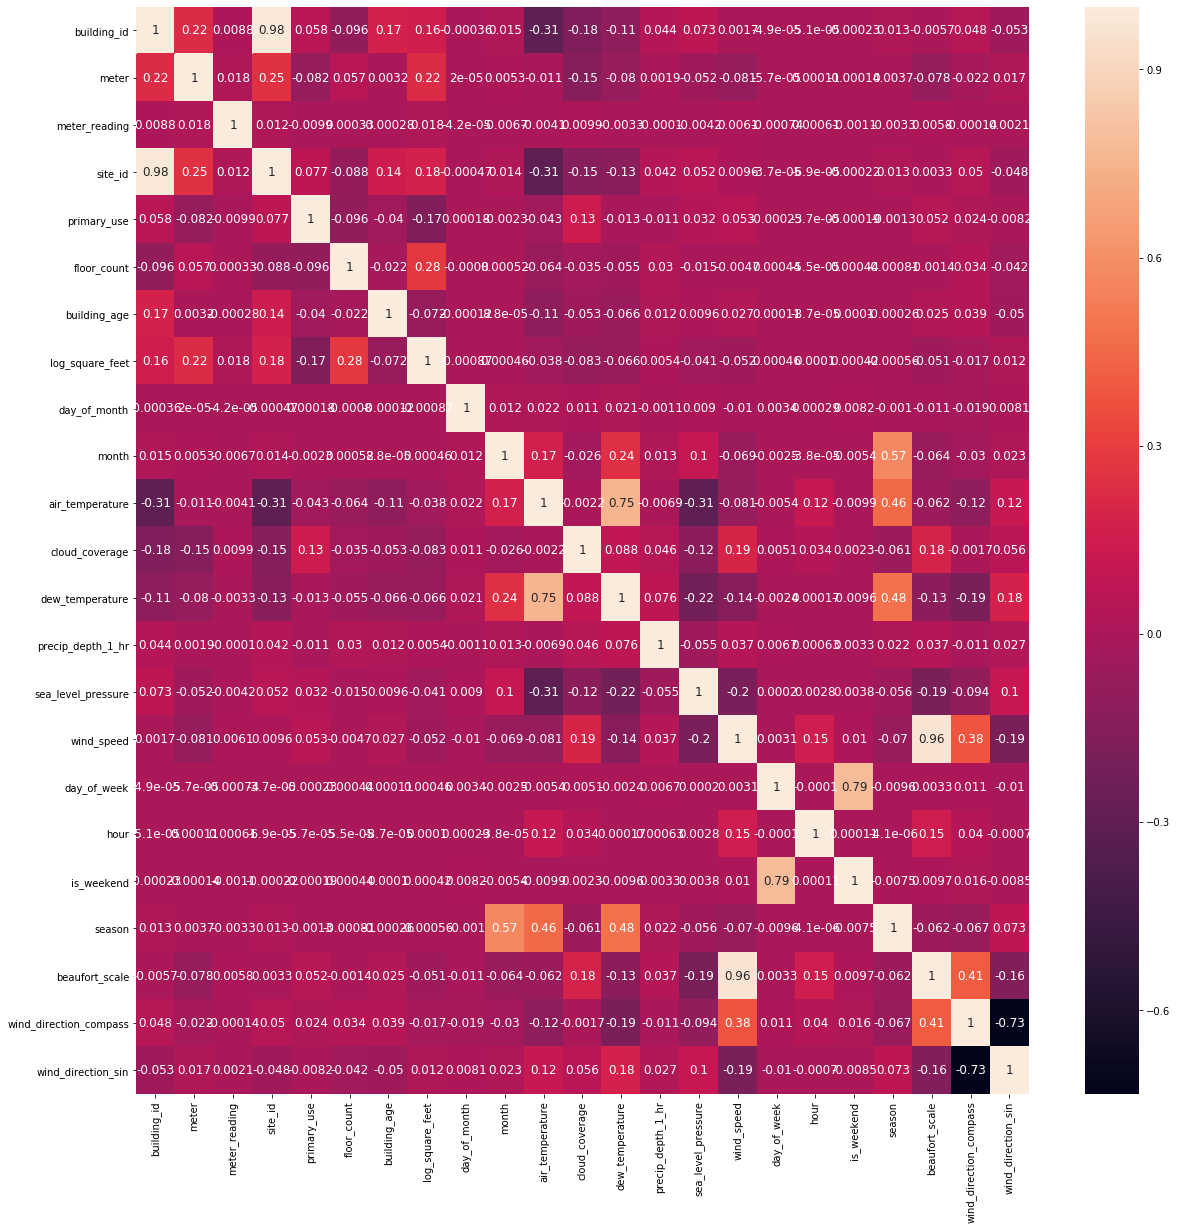

In [82]:
corr_mat = train_copy.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_mat, annot=True, annot_kws={'size': 12})

### Modeling
  - Trying Gradient Boosting ML Model
  - Trying Deep Neural Network
  - Hyperparameter tuning and K-Fold pipeline
  - Trying LSTM Network (WIP)


#### Train-test split

In [0]:
unnecessary_features = ['timestamp', 'day_of_month']

categoricals = ['building_id', 'site_id', 'meter', 'primary_use', 'floor_count',
                'cloud_coverage', 'beaufort_scale', 'wind_direction_compass',
                'day_of_week', 'hour', 'is_weekend', 'season']

numericals = ["building_age", "log_square_feet", "air_temperature", "dew_temperature",
              "precip_depth_1_hr", "sea_level_pressure", "wind_speed", "wind_direction_sin"]

target = "meter_reading"

features = categoricals + numericals

In [0]:
# TRAIN_SIZE = 1047552
# train_sample = train.sample(TRAIN_SIZE)

X = train_copy[features]
y = train_copy[target].map(np.log1p)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### LightGBM Model

In [0]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

seed = 42
shuffle = False


lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categoricals)
lgb_eval = lgb.Dataset(X_test, y_test, categorical_feature=categoricals)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=50,
                verbose_eval = 50
)


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 0.786174	valid_1's rmse: 0.79386
[100]	training's rmse: 0.738058	valid_1's rmse: 0.751831
[150]	training's rmse: 0.708276	valid_1's rmse: 0.727717
[200]	training's rmse: 0.685639	valid_1's rmse: 0.709861
[250]	training's rmse: 0.669835	valid_1's rmse: 0.698331
[300]	training's rmse: 0.657641	valid_1's rmse: 0.690109
[350]	training's rmse: 0.646697	valid_1's rmse: 0.682972
[400]	training's rmse: 0.634655	valid_1's rmse: 0.67526
[450]	training's rmse: 0.624417	valid_1's rmse: 0.669063
[500]	training's rmse: 0.61564	valid_1's rmse: 0.663984
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.61564	valid_1's rmse: 0.663984


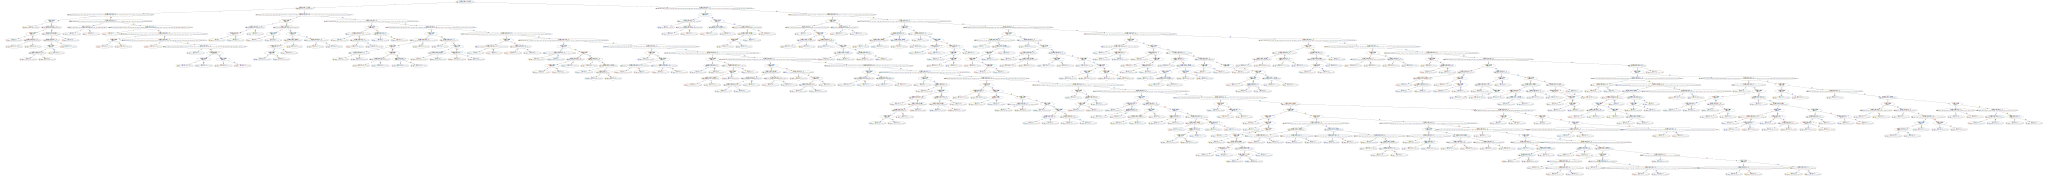

In [0]:
lgb.create_tree_digraph(gbm)

#### Neural Network Model

In [0]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

def create_model(dense_layer_sizes, opt="adam", dropout=0.1, nbr_features=20, dense_nparams=256, lr=0.01):
    optimizers = {
        'adam': Adam(lr),
        'rmsprop': RMSprop(lr)
    }
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(nbr_features,))) 
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizers[opt], metrics=[root_mean_squared_error])
    return model

In [0]:
model = create_model(dense_layer_sizes=[256, 128, 64, 32], dense_nparams=512, dropout=0.2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               10752     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

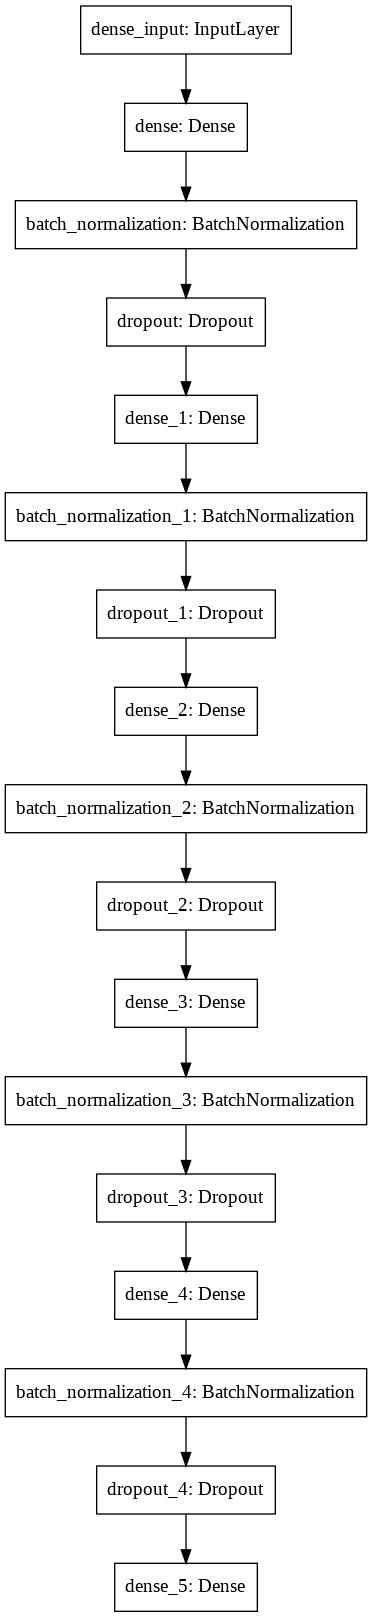

In [0]:
plot_model(model)

In [0]:
EPOCHS = 50
BATCH_SIZE = 1024

In [0]:
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.9
   lrate = initial_lrate * math.pow(drop, math.floor((epoch)))
   return lrate

best_model_file = "/content/gdrive/My Drive/Models/epochs:{epoch:03d}-val_loss:{val_loss:.3f}.h5"
# best_model_file = "epochs:{epoch:03d}-val_loss:{val_loss:.3f}.h5"

mc = ModelCheckpoint(best_model_file, monitor='val_loss', mode='auto',verbose=True, save_best_only=True)
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=True, mode='auto', restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=True, min_delta=0.001, min_lr=1e-5)
lrs = LearningRateScheduler(step_decay, verbose=True)

In [0]:
hist = model.fit(X_train.values, y_train.values, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                 validation_data=(X_test.values, y_test.values), verbose=True, callbacks=[es, mc, rlr])

Train on 15162075 samples, validate on 5054025 samples
Epoch 1/50
15161344/15162075 [============================>.] - ETA: 0s - loss: 2.4783 - root_mean_squared_error: 1.5678
Epoch 00001: val_loss improved from inf to 6.40611, saving model to /content/gdrive/My Drive/Models/epochs:001-val_loss:6.406.h5
15162075/15162075 [==============================] - 501s 33us/sample - loss: 2.4783 - root_mean_squared_error: 1.5677 - val_loss: 6.4061 - val_root_mean_squared_error: 2.5298
Epoch 2/50
15160320/15162075 [============================>.] - ETA: 0s - loss: 2.0827 - root_mean_squared_error: 1.4420
Epoch 00002: val_loss improved from 6.40611 to 3.42198, saving model to /content/gdrive/My Drive/Models/epochs:002-val_loss:3.422.h5
15162075/15162075 [==============================] - 507s 33us/sample - loss: 2.0827 - root_mean_squared_error: 1.4420 - val_loss: 3.4220 - val_root_mean_squared_error: 1.8490
Epoch 3/50
15160320/15162075 [============================>.] - ETA: 0s - loss: 1.9888 - 

In [0]:
best_model_filepath = "/content/gdrive/My Drive/Models/epochs:029-val_loss:1.264.h5"
dependencies = {
    'root_mean_squared_error': root_mean_squared_error
}

best_model = load_model(best_model_filepath, custom_objects=dependencies)

#### Hyperparameter tuning and KFold Cross validation pipeline

In [0]:
keras_estimator = KerasRegressor(create_model, epochs=20, batch_size=1024, verbose=2)
keras_estimator.get_params()

In [0]:
dense_size_candidates = [[64, 32], [128, 64, 32], [256, 128, 64, 32], 
                         [256, 128, 64, 64, 32, 16], [512, 256, 128, 128, 64, 32]]
param_grid = {
    'dense_nparams': [128, 256, 384, 512, 640, 768, 896, 1024],
    'dense_layer_sizes': dense_size_candidates,
    'opt':['rmsprop', 'adam'],
    'lr': [0.001, 0.002, 0.05. 0.01],
    'dropout': [0.5, 0.3, 0.2, 0.1, 0]
}

In [0]:
kfold_splits = 4
tuner = RandomizedSearchCV(estimator=keras_estimator,
                    verbose=True,
                    n_iter=25,
                    n_jobs=-1
                    return_train_score=True,
                    cv=kfold_splits,
                    param_distributions=param_grid)

In [0]:
# es = EarlyStopping(monitor='loss', min_delta=0.01, patience=5, verbose=True, mode='auto', restore_best_weights=True)
# rlr = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.75, verbose=True, min_delta=0.01, min_lr=1e-5)

# tuner_result = tuner.fit(X_train, y_train, callbacks=[es, rlr])

# # summarize results
# print("Best: %f using %s" % (tuner_result.best_score_, tuner_result.best_params_))
# means = tuner_result.cv_results_['mean_test_score']
# stds = tuner_result.cv_results_['std_test_score']
# params = tuner_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

#### Trying LSTM Network (TODO)

### Testing and submitting results


*   Applying data processing pipeline on test dataset
*   Getting predictions of test data
*   Submitting results using Kaggle CLI



#### Data processing pipeline on test dataset

In [0]:
%%time
test_copy = data_processing_pipeline(test, weather_test, building)

Data cleaning: Fixing timestamp

Processing building data:

Data cleaning: Replacing null values for floor_count column
Feature engineering: Creating building_age column
Data Cleaning: Deleting floor_count column
Data cleaning: Replacing null values in building_age column
Feature engineering: Label encoding primary use
Feature engineering: Log normalization for square_feet column

Processing weather data:

Data cleaning: Converting timestamp column
Feature engineering: Adding month, day of week, day of month and hour columns
Feature engineering: Adding is_weekend feature
Feature engineering: Adding season feature
Data cleaning: Replacing NAN values
Data cleaning: Replacing NAN values for air_temperature
Data cleaning: Replacing NAN values for dew_temperature
Data cleaning: Replacing NAN values for wind_speed
Data cleaning: Replacing NAN values for wind_direction
Data cleaning: Replacing NAN values for sea_level_pressure
Data cleaning: Replacing NAN values for precip_depth_1_hr
Data cle

#### Getting predictions

In [0]:
test_data = test_copy[features]
y_pred = best_model.predict(test_data.values, batch_size=1024, verbose=1)

41697600/41697600 [==============================] - 282s 7us/sample


#### Creating submission .csv and submitting results

In [0]:
sample_submission['meter_reading'] = np.expm1(y_pred)

In [0]:
export_csv = sample_submission.to_csv('./my-submission.csv', index=False)

In [0]:
!kaggle competitions submit ashrae-energy-prediction -f my-submission.csv -m 'Final submission'

100% 727M/727M [00:16<00:00, 46.2MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III